Baseline Recommender System Notebook

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml import recommendation
import pandas as pd

In [77]:
spark_df = (spark.read.format("csv").options(header="true")
    .load("../data/housing-data-new-test.csv"))

In [78]:
df = spark_df.toPandas()

In [11]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=427471138)

In [89]:
als_model = recommendation.ALS(
#     itemCol='1',
#     userCol='',
#     ratingCol='2',
    nonnegative=True,    
    regParam=0.1,
    rank=10) 

In [224]:
recommender = als_model.fit(train)

IllegalArgumentException: 'requirement failed: Column LABEL must be of type NumericType but was actually of type StringType.'

In [14]:
df = pd.read_csv('../data/housing-data-new-test.csv')

In [15]:
df_fav = pd.read_csv('../data/favorites_test.csv')

In [49]:
tfidf = TfidfVectorizer(stop_words='english', max_features=500)
km = KMeans(n_clusters=50)

tfidf.fit(df.DESC.values)
desc_tfidf = tfidf.transform(df.DESC.values)
km.fit(desc_tfidf.todense())

df['LABEL'] = pd.Series(km.labels_)

In [16]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

class Clustering:
    def __init__(self, n_clusters=30):
        '''Initializes the TFIDF Vectorizer and KMeans Obj'''

        self.n_clusters = n_clusters
        self.tfidf = TfidfVectorizer(stop_words='english', max_features=500)
        self.km = KMeans(n_clusters=self.n_clusters)


    def fit_transform(self, X):
        '''Fits and transforms TFIDF and fits KMeans.

        Params:
            X (array): Array of the descriptions of houses

        '''
        self.tfidf.fit(X)
        desc_tfidf = self.tfidf.transform(X)
        self.km.fit(desc_tfidf.todense())
        return desc_tfidf

    def result(self, df):
        '''Takes the df and builds a column with the labels for each house.

        Params:
            df (DataFrame): dataframe with all the housing data


        Returns:
            df (DataFrame): dataframe including new column for label

        '''
        df['LABEL'] = pd.Series(self.km.labels_)
        return df

    def predictions(self, df):
        '''Returns houses that are in the same clusters as their favorites.

        Params:
            df (DataFrame): entire dataframe with the favorites and the cluster labels

        Returns:
            pos (DataFrame): dataframe of houses that have similar descriptions 
                to those that they favorited

        '''
        list_of_rows = []
        possible_clusters = df[df['FAVORITED'] == 'Y']['LABEL'].unique()
        for idx, row in df.iterrows():
            if row['LABEL'] in possible_clusters and row['FAVORITED'] == 'N':
                list_of_rows.append(row)
        return pd.concat(list_of_rows)

def get_data(file, fave_file=None):
    '''Takes in a filename and returns it as a dataframe.


    Params:
        file (csv): file in csv format

    Returns:
        df (DataFrame): pandas dataframe of data from file
    '''
    df = pd.read_csv(file)
    df['FAVORITE'] = 'N'    
    if fave_file != None:
        df_faves = pd.read_csv(fave_file)
        for idx, row in df.iterrows():
            if row['ADDRESS'] in list(df_faves['ADDRESS']):
                df.loc[idx,'FAVORITE'] = 'Y'
    df.rename(columns={'$/SQUARE FEET': 'PRICE/SQUAREFT'})
    df['DESC'] = df['DESC'].fillna('No Description')
    df = df.fillna(0)
    df.drop(df[df['STATE'] != 'WA'].index, inplace=True)
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', inplace=True, axis=1)
    df.drop_duplicates(inplace=True)
    return df

In [43]:
df = get_data('../data/housing-data.csv', '../data/favorites_test.csv')
cluster = Clustering()
tfidf = cluster.fit_transform(df.DESC.values)
df = cluster.result(df)
# preds = cluster.predictions(df)

AttributeError: 'KMeans' object has no attribute 'labels_'

In [18]:
matrix = pd.DataFrame(tfidf.todense())

In [19]:
users = pd.DataFrame()

In [20]:
fave = pd.read_csv('../data/favorites_test.csv')

In [21]:
fave['user_id'] = 1

In [22]:
df.index.rename('house_id', inplace=True)

In [23]:
fave['rating'] = 1

In [24]:
users = pd.concat([fave['user_id'], pd.Series(df[df['FAVORITE'] == 'Y'].index), fave['rating']], axis=1)

In [25]:
users = users.fillna(1)

In [26]:
users

,user_id,house_id,rating
0,1.0,840,1.0
1,1.0,999,1.0
2,1.0,1003,1.0
3,1.0,1043,1.0
4,1.0,1273,1.0
5,1.0,1331,1.0
6,1.0,1345,1.0
7,1.0,1463,1.0


In [27]:
users.to_csv('../data/users.csv')

In [28]:
import numpy as np

In [29]:
def build_user_matrix(users, new_user):
    ''' Adds new user data to users dataframe
    
    Params:
        users (file): existing file for the users data
        new_user (file): df with favorited col updated for user
    '''
    users = pd.read_csv(users)
    df = get_data('../data/housing-data.csv', new_user)
    house_id = list(users['house_id'])
    ratings = list(users['rating'])
    user_id = list(users['user_id'])
    df['rating'] = df['FAVORITE'].apply(lambda x: 1 if x == 'Y' else 0)
    df['user_id'] = df['FAVORITE'].apply(lambda x: (users.user_id.max() + 1) if x == 'Y' else 0)
    df = df.drop(df[df['user_id'] == 0].index)
    user_id.extend(list(df['user_id']))
    house_id.extend(list(df[df['FAVORITE'] == 'Y'].index))
    ratings.extend(list(df['rating']))
    users = pd.concat([pd.Series(user_id), pd.Series(house_id), pd.Series(ratings)], axis=1)
    users = users.rename(columns={0:'user_id', 1:'house_id', 2:'rating'})
    users.to_csv('../data/users.csv')
    return users

In [30]:
build_user_matrix('../data/users.csv', '../data/redfin-favorites_erepp.csv')
build_user_matrix('../data/users.csv', '../data/redfin-favorites_repp-el.csv')
build_user_matrix('../data/users.csv', '../data/redfin-favorites_travels.csv')

,user_id,house_id,rating
0,1.0,840,1.0
1,1.0,999,1.0
2,1.0,1003,1.0
3,1.0,1043,1.0
4,1.0,1273,1.0
5,1.0,1331,1.0
6,1.0,1345,1.0
7,1.0,1463,1.0
8,2.0,231,1.0
9,2.0,238,1.0


In [31]:
users = pd.read_csv('../data/users.csv')

In [32]:
# Setup a SparkSession
spark = SparkSession.builder.getOrCreate()

In [33]:
spark_df = spark.createDataFrame(users)

In [34]:
df = spark_df.toPandas()

In [35]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=427471138)

In [36]:
als_model = recommendation.ALS(
    itemCol='house_id',
    userCol='user_id',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10) 

In [37]:
recommender = als_model.fit(train)

In [40]:
rec = recommender.recommendForAllUsers(2)

In [41]:
rec.collect()

[Row(user_id=1, recommendations=[Row(house_id=1003, rating=0.9019344449043274), Row(house_id=1043, rating=0.9004920125007629)]),
 Row(user_id=3, recommendations=[Row(house_id=1180, rating=0.9005714058876038), Row(house_id=2380, rating=0.9005714058876038)]),
 Row(user_id=4, recommendations=[Row(house_id=1921, rating=0.9010143280029297), Row(house_id=2131, rating=0.9010143280029297)]),
 Row(user_id=2, recommendations=[Row(house_id=231, rating=0.9011317491531372), Row(house_id=1671, rating=0.9011317491531372)])]

In [42]:
users_houses = users

In [ ]:
for idx, row in df.iterrows():
    

In [70]:
price_sorted = df.sort_values(by=['PRICE', 'LABEL'], ascending=[False, False])

In [71]:
price_sorted['LABEL'] = price_sorted['LABEL'].fillna(0)

In [82]:
price_sorted.shape[0]/30

94.06666666666666

In [83]:
one = price_sorted[0:200].sample(150)
two = price_sorted[200:400].sample(150)
three = price_sorted[400:600].sample(150)
four = price_sorted[600:800].sample(150)
five = price_sorted[800:1000].sample(150)
six = price_sorted[1000:1200].sample(150)
seven = price_sorted[1200:1400].sample(150)
eight = price_sorted[1400:1600].sample(150)
nine = price_sorted[1600:1800].sample(150)
ten = price_sorted[1800:2000].sample(150)
el = price_sorted[2000:].sample(150)

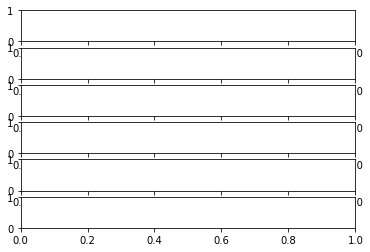

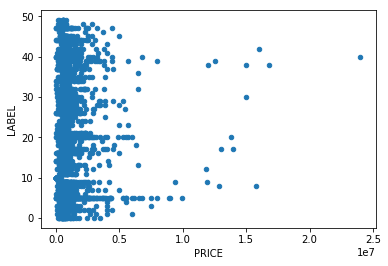

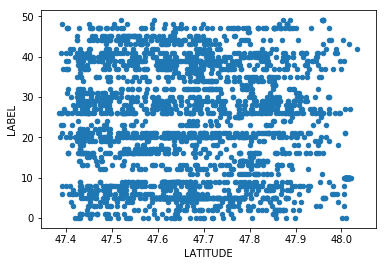

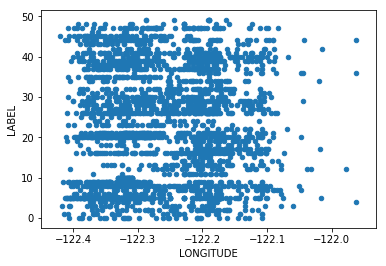

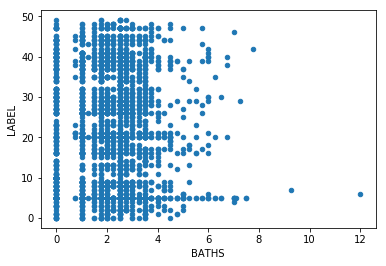

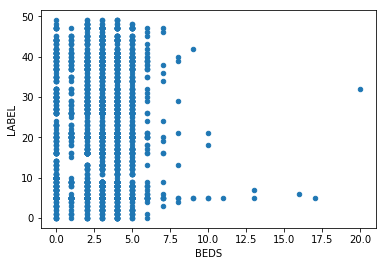

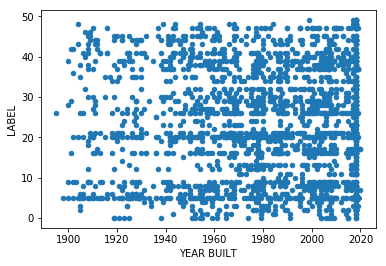

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(6)
ax[0]=df.plot.scatter('PRICE', 'LABEL')
ax[1]=df.plot.scatter('LATITUDE', 'LABEL')
ax[2]=df.plot.scatter('LONGITUDE', 'LABEL')
ax[3]=df.plot.scatter('BATHS', 'LABEL')
ax[4]=df.plot.scatter('BEDS', 'LABEL')
ax[5]=df[df['YEAR BUILT']!=0].plot.scatter('YEAR BUILT', 'LABEL')

In [85]:
samples = [one, two, three, four, five, six, seven, eight, nine, ten, el]

In [ ]:
for i, item in enumerate(samples):
    for j in range(3):
        for idx in list(item.sample(100).index):
            item.loc[idx, 'FAVORITE'] = 'Y'
        item = item.drop(item[item['FAVORITE'] != 'Y'].index)
        print(item['FAVORITE'].value_counts())
#         item.to_csv('../data/{}-{}'.format(i, j))

Y    143
Name: FAVORITE, dtype: int64


/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Y    143
Name: FAVORITE, dtype: int64
Y    143
Name: FAVORITE, dtype: int64
Y    115
Name: FAVORITE, dtype: int64
Y    115
Name: FAVORITE, dtype: int64
Y    115
Name: FAVORITE, dtype: int64
Y    119
Name: FAVORITE, dtype: int64


,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE,ZIP,PRICE,BEDS,BATHS,...,NEXT OPEN HOUSE END TIME,URL,SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE,DESC,LABEL
1654,MLS Listing,0.0,Single Family Residential,20200 10th Place SW,Normandy Park,WA,98166,24000000.0,4,6.75,...,0,http://www.redfin.com/WA/Normandy-Park/10th-Pl...,NWMLS,1274902,N,Y,47.419677,-122.348047,The Hidden Valley Estate. A private retreat to...,40.0
944,MLS Listing,0.0,Single Family Residential,0,Seattle,WA,98144,16800000.0,4,4.50,...,0,http://www.redfin.com/WA/Seattle/Undisclosed-a...,NWMLS,1282862,N,Y,47.594800,-122.309746,Privacy & elegance along the shores of Lake Wa...,38.0
2211,MLS Listing,0.0,Single Family Residential,3905 Lake Washington Blvd N,Renton,WA,98056,16000000.0,9,7.75,...,0,http://www.redfin.com/WA/Renton/3905-Lake-Wash...,NWMLS,1255553,N,Y,47.526985,-122.204906,Unique. Historic. One-of-a-kind. Exclusive. Lu...,42.0
2571,MLS Listing,0.0,Vacant Land,81017 Undisclosed,Bellevue,WA,98004,15780000.0,0,0.00,...,0,http://www.redfin.com/WA/Bellevue/81017-Undisc...,NWMLS,1176662,N,Y,47.632936,-122.187188,Rare opportunity to acquire prime block of pro...,8.0
2578,MLS Listing,0.0,Single Family Residential,0,Bellevue,WA,98005,15000000.0,5,6.75,...,0,http://www.redfin.com/WA/Bellevue/Undisclosed-...,NWMLS,1045500,N,Y,47.636015,-122.181077,Outstanding execution of this gated Bridle Tra...,38.0
1258,MLS Listing,0.0,Single Family Residential,814 E Highland Dr,Seattle,WA,98102,15000000.0,5,6.50,...,0,http://www.redfin.com/WA/Seattle/814-E-Highlan...,NWMLS,1002540,N,Y,47.630656,-122.321502,No Description,30.0
2451,MLS Listing,0.0,Single Family Residential,18110 SE 41st Lane,Bellevue,WA,98008,13989000.0,4,5.25,...,0,http://www.redfin.com/WA/Bellevue/18110-SE-41s...,NWMLS,1279837,N,Y,47.571610,-122.098434,Extraordinary Brilliance on Lake Sammamish. A ...,17.0
1252,MLS Listing,0.0,Condo/Co-op,Undisclosed,Seattle,WA,98121,13800000.0,3,4.00,...,0,http://www.redfin.com/WA/Seattle/843-Hiawatha-...,NWMLS,1072148,N,Y,47.617687,-122.353734,No Description,20.0
2877,MLS Listing,0.0,Single Family Residential,13255 NE 97th,Kirkland,WA,98033,13500000.0,5,3.25,...,0,http://www.redfin.com/WA/Kirkland/13255-NE-97t...,NWMLS,1203012,N,Y,47.686869,-122.162450,The Ponderosa- Bring your investors and builde...,0.0
2487,MLS Listing,0.0,Single Family Residential,719 96th Ave SE,Bellevue,WA,98004,12980000.0,5,5.75,...,0,http://www.redfin.com/WA/Bellevue/719-96th-Ave...,NWMLS,1268716,N,Y,47.603259,-122.211608,"Open the door to the 180-degree"" Exquisite Vie...",17.0
